In [76]:
import tensorflow as tf
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from example_lorenz import get_lorenz_data, generate_lorenz_data
#from autoencoder import full_network
#from training import create_feed_dictionary
#from sindy_utils import sindy_simulate
#from sindy_utils import sindy_library
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shallowNet.shallowNet import shallowNet, DenseTranspose
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from typing import List, Tuple, Union
%matplotlib inline

In [2]:
data_path = os.getcwd() + '/'
save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [7]:
test_data.keys()

dict_keys(['t', 'y_spatial', 'modes', 'x', 'dx', 'ddx', 'z', 'dz', 'ddz', 'sindy_coefficients'])

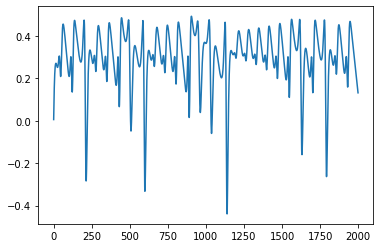

In [13]:
test_data['x'][:,0]

In [107]:
z = tf.stack(test_data['x'][:16])
latent_dim = 3
poly_order = 2
include_sine = True
library = [tf.ones(tf.shape(z)[0])]

def sindy_library_tf(z, latent_dim, poly_order, include_sine=False):
    """
    !!!! TF2 - VERSION !!!!
    
    Build the SINDy library.

    Arguments:
        z - 2D tensorflow array of the snapshots on which to build the library. Shape is number of
        time points by the number of state variables.
        latent_dim - Integer, number of state variable in z.
        poly_order - Integer, polynomial order to which to build the library. Max value is 5.
        include_sine - Boolean, whether or not to include sine terms in the library. Default False.

    Returns:
        2D tensorflow array containing the constructed library. Shape is number of time points by
        number of library functions. The number of library functions is determined by the number
        of state variables of the input, the polynomial order, and whether or not sines are included.
    """

    # add constant term to the set of equation
    library = [tf.ones(tf.shape(z)[0])]

    # add: x, y, z
    for i in range(latent_dim):
        library.append(z[:,i])

    # add: xx + zz + yy + xy + xz + yz
    if poly_order > 1:
        print("call poly 1")
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                library.append(z[:,i]*z[:,j])
                #library.append(tf.math.multiply(z[:,i], z[:,j]))

    # anologically to the comment above
    if poly_order > 2:
        print("call poly 2")
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    library.append(z[:,i]*z[:,j]*z[:,k])
                    #library.append(tf.math.multiply(tf.math.multiply(z[:,i], z[:,j]), z[:,k]))

    # anologically to the comment above
    if poly_order > 3:
        print("call poly 3")
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    for p in range(k,latent_dim):
                        library.append(z[:,i]*z[:,j]*z[:,k]*z[:,p])
                        #library.append(tf.math.multiply(tf.math.multiply(tf.math.multiply(z[:,i], z[:,j]), z[:,k]), z[:p]))

    # anologically to the comment above
    if poly_order > 4:
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    for p in range(k,latent_dim):
                        for q in range(p,latent_dim):
                            library.append(z[:,i]*z[:,j]*z[:,k]*z[:,p]*z[:,q])
                            #library.append(tf.math.multiply(tf.math.multiply(tf.math.multiply(tf.math.multiply(z[:,i], z[:,j]), z[:,k]), z[:p]), z[:q]))

    # add: sin(x), sin(y), sin(z)
    if include_sine:
        for i in range(latent_dim):
            library.append(np.sin(z[:,i]))
            
    return tf.convert_to_tensor(np.stack(library, axis = 1))

r = sindy_library_tf(z, 3, 2, False)


call poly 1


In [111]:
Input(shape=(r.shape[0],)) 

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'input_7')>

In [ ]:

def build_network_layers(
    encoding_layers_size = [32, 28], 
    layers_params = [{'l1' : 0.0001, 'l2' : 0.0, 'dropout' : 0.0}, {}],
    layers_default_params = {'l1' : 0.0001, 'l2' : 0.0, 'dropout' : 0.0, 'activation' : "tanh"},
    loss = "mse",
    optimizer =  tf.keras.optimizers.Adam,
    learning_rate = 0.0001,
    metrics = None
    ) -> tf.keras.Model:

    # initialize input layer 
    input_size = encoding_layers_size[0]
    inputs = Input(shape=(input_size,))

    # add empty dicionaries to layers_params to corecponds to the encoding_layers_size size
    for _ in range(len(encoding_layers_size) - len(layers_params)):
        layers_params.append({})

    # remove firs instance 
    encoding_layers_size = encoding_layers_size[1:]

    # fill missing values in layers_params using default values 
    layers_params = [{**layers_default_params, **x} for x in layers_params]
    
    #initalize arrays to hold encoding and decoding layers 
    encoders = []
    decoders = []

    for l_size, l_param in zip(encoding_layers_size, layers_params):
        
        encoders.append(Dropout(l_param['dropout']))

        # construct encoding layer 
        encoding_layer = Dense(
            units = l_size,
            activation=l_param['activation'],
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
            bias_initializer=tf.keras.initializers.Zeros(),
            kernel_regularizer=tf.keras.regularizers.L1L2(l_param['l1'], l_param['l2']),
        )
        # add encoding layer to the array of encoding layer
        encoders.append(encoding_layer)
       
        # construct decoding layer as dense transpose of encoding layer 
        decoders.append(DenseTranspose(dense=encoding_layer))

    # reverse decoders array 
    decoders = decoders[::-1]

    # stack layers to form auto-encoder architecture
    stacked_layers = inputs
    for layer in encoders + decoders:
        stacked_layers = layer(stacked_layers)

    model = tf.keras.Model(inputs, stacked_layers)

    opt = optimizer(learning_rate=learning_rate)
    if metrics == None:
        model.compile(loss=loss, optimizer=opt)
    else:
        model.compile(loss=loss, optimizer=opt, metrics=metrics)
    return model

In [84]:
def tmp(tup : Optional[Tuple[str,str]]= ("a", "b")):
    print(tup[0], tup[1])
tmp()

a b


In [166]:
from typing import List, Tuple, Union, Optional

def build_autoencoder(
    input_dim : int,
    min_dim : int,
    width : List[int],
    transposed_decoder : Optional[bool] = True,
    activation  = "tanh",
    loss = "mse",
    optimizer = "Adam",
    metrics = ["mae", "acc"],
    name : Tuple[str, str] = ('encoder', 'decoder')
    ) -> Tuple[tf.keras.Model, tf.keras.Model, tf.keras.Model]:
    """
    Unfortunately, at the time of writing this code
    python typing did not support all keras types:
    https://github.com/tensorflow/tensorflow/issues/46337

    If if it will be resolved, types above can be improved:
        activation : Optional[Union[tf.keras.activations, str]] = "tanh",
        loss : Optional[Union[tf.keras.losses, str]] = "mse",
        optimizer : Optional[Union[str, tf.keras.optimizers] = "Adam",
        metrics : Optional[List[Union[str, tf.keras.metrics], tf.keras.metrics, str] = ["mae", "acc"]

    !!! my previous kernal initializer was: tf.keras.initializers.RandomNormal(stddev=0.01)
    """
    
    name_encoder = 'endocer' if name[0]==None else name[0] 
    name_decoder = 'decoder' if name[1]==None else name[1]

    encoder_layers = [Input(shape=(input_dim, ), name = name_encoder + '_input')]
    decoder_layers = [Input(shape=(min_dim, ), name = name_decoder + '_input')]

    for layer_index, layer_dim in enumerate(width):
        # construct encoder layer 
        encoder_layers.append(
            Dense(
                units = layer_dim,
                activation=activation, 
                kernel_initializer=tf.keras.initializers.GlorotUniform(),
                bias_initializer=tf.keras.initializers.Zeros(),
                name = name_encoder + "_{}".format(layer_index)
                )
            )
    encoder_layers.append(
        Dense(
            units = min_dim,
            activation=activation, 
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.Zeros(),
            name = name_encoder + "_output"
            )
        )

    if transposed_decoder:
        for layer_index, layer in enumerate(encoder_layers[::-1][:-1]):
            # construct decoder layer
            decoder_layers.append(
                DenseTranspose(
                    dense = layer,
                    name = name_decoder + "_{}".format(layer_index)
                    )
                )
    else:
        for layer_index, layer in enumerate(width[::-1]):
            # construct decoder layer 
            decoder_layers.append(
                Dense(
                    units = layer.input_shape[-1],
                    activation=activation, 
                    kernel_initializer=tf.keras.initializers.GlorotUniform(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    name = name_decoder + "_{}".format(layer_index)
                    )
                )
        decoder_layers.append(
            Dense(
                units = input_dim,
                activation=activation, 
                kernel_initializer=tf.keras.initializers.GlorotUniform(),
                bias_initializer=tf.keras.initializers.Zeros(),
                name = name_decoder + "_{}".format(layer_index)
                )
            )

    # stack encoder layers into encoder
    encoder_input = encoder_layers[0]
    x = encoder_input
    for encoder_layer in encoder_layers[1:]:
        x = encoder_layer(x)
    
    # build encoder
    encoder = tf.keras.Model(encoder_input, x)
    encoder.compile(loss = loss, optimizer = optimizer, metrics=metrics)

    # stack decoder layers into decoder
    decoder_input = decoder_layers[0]
    z = decoder_input
    for decoder_layer in decoder_layers[1:]:
        z = decoder_layer(z)
    
    # build decoder
    decoder = tf.keras.Model(decoder_input, z)
    decoder.compile(loss = loss, optimizer = optimizer, metrics=metrics)

    # interation over encoder/decoder is intended to keep consistant layer naming
    autoencoder_input = encoder_layers[0]
    y = autoencoder_input
    for autoencoder_layer in encoder_layers[1:] + decoder_layers[1:]:
        y = autoencoder_layer(y)

    # build autoencoder
    autoencoder = tf.keras.Model(autoencoder_input, y)
    autoencoder.compile(loss = loss, optimizer = optimizer, metrics=metrics)

    return autoencoder, encoder, decoder

a, e, d = build_autoencoder(32, 8, [24, 16])

In [167]:
a.summary()

Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 24)                792       
_________________________________________________________________
encoder_1 (Dense)            (None, 16)                400       
_________________________________________________________________
encoder_output (Dense)       (None, 8)                 136       
_________________________________________________________________
decoder_0 (DenseTranspose)   (None, 16)                152       
_________________________________________________________________
decoder_1 (DenseTranspose)   (None, 24)                424       
_________________________________________________________________
decoder_2 (DenseTranspose)   (None, 32)                824

In [57]:
input_l = Input(shape=(mod.layers[-1].output_shape[-1], ), name = '_input')
x = DenseTranspose(dense = mod.layers[-1])(input_l)
tf.keras.Model(input_l, x)



In [ ]:
"""Good autoencoder with nice dict args"""
def build_autoencoder(
    encoding_layers_size = [32, 28], 
    layers_params = [{'l1' : 0.0001, 'l2' : 0.0, 'dropout' : 0.0}, {}],
    layers_default_params = {'l1' : 0.0001, 'l2' : 0.0, 'dropout' : 0.0, 'activation' : "tanh"},
    loss = "mse",
    optimizer =  tf.keras.optimizers.Adam,
    learning_rate = 0.0001,
    metrics = None
    ):

    # initialize input layer 
    input_size = encoding_layers_size[0]
    inputs = Input(shape=(input_size,))

    # add empty dicionaries to layers_params to corecponds to the encoding_layers_size size
    for _ in range(len(encoding_layers_size) - len(layers_params)):
        layers_params.append({})

    # remove firs instance 
    encoding_layers_size = encoding_layers_size[1:]

    # fill missing values in layers_params using default values 
    layers_params = [{**layers_default_params, **x} for x in layers_params]
    
    #initalize arrays to hold encoding and decoding layers 
    encoders = []
    decoders = []

    for l_size, l_param in zip(encoding_layers_size, layers_params):
        
        # if dropout is different than 0 then add dropout layer
        #if l_param['dropout'] > 0.0:
        encoders.append(Dropout(l_param['dropout']))


        # construct encoding layer 
        encoding_layer = Dense(
            units = l_size,
            activation=l_param['activation'],
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
            bias_initializer=tf.keras.initializers.Zeros(),
            kernel_regularizer=tf.keras.regularizers.L1L2(l_param['l1'], l_param['l2']),
        )
        # add encoding layer to the array of encoding layer
        encoders.append(encoding_layer)
       
        # construct decoding layer as dense transpose of encoding layer 
        decoders.append(DenseTranspose(dense=encoding_layer))

    # remove dropout layer after the bottlenect layer
    #if(type(encoders[-1]) == type(Dropout(0.0))):
    #    encoders.pop()

    # reverse decoders array 
    decoders = decoders[::-1]

    # stack layers to form auto-encoder architecture
    stacked_layers = inputs
    for layer in encoders + decoders:
        stacked_layers = layer(stacked_layers)

    model = tf.keras.Model(inputs, stacked_layers)

    opt = optimizer(learning_rate=learning_rate)
    if metrics == None:
        model.compile(loss=loss, optimizer=opt)
    else:
        model.compile(loss=loss, optimizer=opt, metrics=metrics)
    return model

In [54]:
"""Good model building"""

from typing import List, Tuple, Union, Optional

def build_autoencoder(
    input_dim : int,
    min_dim : int,
    width : List[int],
    transposed_decoder : Optional[bool] = True,
    activation  = "tanh",
    loss = "mse",
    optimizer = "Adam",
    metrics = ["mae", "acc"],
    name : Tuple[str, str] = ('encoder', 'decoder')
    ) -> Tuple[tf.keras.Model, tf.keras.Model, tf.keras.Model]:
    """
    Unfortunately, at the time of writing this code
    python typing did not support all keras types:
    https://github.com/tensorflow/tensorflow/issues/46337

    If if it will be resolved, types above can be improved:
        activation : Optional[Union[tf.keras.activations, str]] = "tanh",
        loss : Optional[Union[tf.keras.losses, str]] = "mse",
        optimizer : Optional[Union[str, tf.keras.optimizers] = "Adam",
        metrics : Optional[List[Union[str, tf.keras.metrics], tf.keras.metrics, str] = ["mae", "acc"]

    """
    
    name_encoder = 'endocer' if name[0]==None else name[0] 
    name_decoder = 'decoder' if name[1]==None else name[1]

    encoder_layers = [Input(shape=(input_dim, ), name = name_encoder + '_input')]
    decoder_layers = [Input(shape=(min_dim, ), name = name_decoder + '_input')]

    for layer_index, layer_dim in enumerate(width):
        # construct encoder layer 
        encoder_layers.append(
            Dense(
                units = layer_dim,
                activation=activation, 
                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                bias_initializer=tf.keras.initializers.Zeros(),
                name = name_encoder + "_{}".format(layer_index)
                )
            )
    encoder_layers.append(
        Dense(
            units = min_dim,
            activation=activation, 
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
            bias_initializer=tf.keras.initializers.Zeros(),
            name = name_encoder + "_output"
            )
        )

    if transposed_decoder:
        for layer_index, layer in enumerate(encoder_layers[::-1][:-1]):
            # construct decoder layer
            decoder_layers.append(
                DenseTranspose(
                    dense = layer,
                    name = name_decoder + "_{}".format(layer_index)
                    )
                )
    else:
        for layer_index, layer in enumerate(width[::-1]):
            # construct decoder layer 
            decoder_layers.append(
                Dense(
                    units = layer.input_shape[-1],
                    activation=activation, 
                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    name = name_decoder + "_{}".format(layer_index)
                    )
                )
        decoder_layers.append(
            Dense(
                units = input_dim,
                activation=activation, 
                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                bias_initializer=tf.keras.initializers.Zeros(),
                name = name_decoder + "_{}".format(layer_index)
                )
            )

    # stack encoder layers into encoder
    encoder_input = encoder_layers[0]
    x = encoder_input
    for encoder_layer in encoder_layers[1:]:
        x = encoder_layer(x)
    
    # build encoder
    encoder = tf.keras.Model(encoder_input, x)
    encoder.compile(loss = loss, optimizer = optimizer, metrics=metrics)

    # stack decoder layers into decoder
    decoder_input = decoder_layers[0]
    z = decoder_input
    for decoder_layer in decoder_layers[1:]:
        z = decoder_layer(z)
    
    # build decoder
    decoder = tf.keras.Model(decoder_input, z)
    decoder.compile(loss = loss, optimizer = optimizer, metrics=metrics)

    # interation over encoder/decoder is intended to keep consistant layer naming
    autoencoder_input = encoder_layers[0]
    y = autoencoder_input
    for autoencoder_layer in encoder_layers[1:] + decoder_layers[1:]:
        y = autoencoder_layer(y)

    # build autoencoder
    autoencoder = tf.keras.Model(autoencoder_input, y)
    autoencoder.compile(loss = loss, optimizer = optimizer, metrics=metrics)

    return autoencoder, encoder, decoder

a, e, d = build_autoencoder(32, 8, [24, 16])

8

In [63]:
def build_decoder_from_encoder(encoder: tf.keras.models.Model, name : str = "decoder"):
    # reversed list of encoder layers
    decoder_layers = encoder.layers[::-1]
    input_dim = decoder_layers[0].output_shape[-1]
    print(decoder_layers)

    input_layer = Input(shape=(None, input_dim), name = name + '_input')

    x = input_layer
    for layer_index, decoder_layer in enumerate(decoder_layers):
        #  construct decoding layer that is transposed encoding layer
        print(decoder_layer.output_shape)
        x = DenseTranspose(
            decoder_layer
        )(x)

    output_layer = DenseTranspose(
        decoder_layers[-1]
    )(x)

    model = tf.keras.Model(input_layer, output_layer)
    return model 
build_decoder_from_encoder(mod)

[<keras.layers.core.Dense object at 0x7f7e1f55ab00>, <keras.layers.core.Dense object at 0x7f7e1f55a3c8>, <keras.layers.core.Dense object at 0x7f7e1f5dbc18>, <keras.engine.input_layer.InputLayer object at 0x7f7e1f5db7b8>]
(None, 8)
(None, 16)
(None, 24)
[(None, 32)]


TypeError: Dimension value must be integer or None or have an __index__ method, got value '(None, 32)' with type '<class 'tuple'>'

TypeError: 'NoneType' object is not iterable

In [31]:
def build_autoencoder(
    encoding_layers_size = [32, 28], 
    layers_params = [{'l1' : 0.0001, 'l2' : 0.0, 'dropout' : 0.0}, {}],
    layers_default_params = {'l1' : 0.0001, 'l2' : 0.0, 'dropout' : 0.0, 'activation' : "tanh"},
    loss = "mse",
    optimizer =  tf.keras.optimizers.Adam,
    learning_rate = 0.0001,
    metrics = None
    ) -> tf.keras.Model:

    # initialize input layer 
    input_size = encoding_layers_size[0]
    inputs = Input(shape=(input_size,))

    # add empty dicionaries to layers_params to corecponds to the encoding_layers_size size
    for _ in range(len(encoding_layers_size) - len(layers_params)):
        layers_params.append({})

    # remove firs instance 
    encoding_layers_size = encoding_layers_size[1:]

    # fill missing values in layers_params using default values 
    layers_params = [{**layers_default_params, **x} for x in layers_params]
    
    #initalize arrays to hold encoding and decoding layers 
    encoders = []
    decoders = []

    for l_size, l_param in zip(encoding_layers_size, layers_params):
        
        encoders.append(Dropout(l_param['dropout']))

        # construct encoding layer 
        encoding_layer = Dense(
            units = l_size,
            activation=l_param['activation'],
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
            bias_initializer=tf.keras.initializers.Zeros(),
            kernel_regularizer=tf.keras.regularizers.L1L2(l_param['l1'], l_param['l2']),
        )
        # add encoding layer to the array of encoding layer
        encoders.append(encoding_layer)
       
        # construct decoding layer as dense transpose of encoding layer 
        decoders.append(DenseTranspose(dense=encoding_layer))

    # reverse decoders array 
    decoders = decoders[::-1]

    # stack layers to form auto-encoder architecture
    stacked_layers = inputs
    for layer in encoders + decoders:
        stacked_layers = layer(stacked_layers)

    model = tf.keras.Model(inputs, stacked_layers)

    opt = optimizer(learning_rate=learning_rate)
    if metrics == None:
        model.compile(loss=loss, optimizer=opt)
    else:
        model.compile(loss=loss, optimizer=opt, metrics=metrics)
    return model

In [32]:
build_autoencoder().summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 28)                924       
_________________________________________________________________
dense_transpose (DenseTransp (None, 32)                956       
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [104]:
def define_loss(network, params):
    """
    Create the loss functions.

    Arguments:
        network - Dictionary object containing the elements of the network architecture.
        This will be the output of the full_network() function.
    """
    x = network['x']
    x_decode = network['x_decode']
    if params['model_order'] == 1:
        dz = network['dz']
        dz_predict = network['dz_predict']
        dx = network['dx']
        dx_decode = network['dx_decode']
    else:
        ddz = network['ddz']
        ddz_predict = network['ddz_predict']
        ddx = network['ddx']
        ddx_decode = network['ddx_decode']
    sindy_coefficients = params['coefficient_mask']*network['sindy_coefficients']

    losses = {}
    losses['decoder'] = tf.math.reduce_mean((x - x_decode)**2)
    if params['model_order'] == 1:
        losses['sindy_z'] = tf.math.reduce_mean((dz - dz_predict)**2)
        losses['sindy_x'] = tf.math.reduce_mean((dx - dx_decode)**2)
    else:
        losses['sindy_z'] = tf.math.reduce_mean((ddz - ddz_predict)**2)
        losses['sindy_x'] = tf.math.reduce_mean((ddx - ddx_decode)**2)
    losses['sindy_regularization'] = tf.math.reduce_mean(tf.math.abs(sindy_coefficients))
    loss = params['loss_weight_decoder'] * losses['decoder'] \
           + params['loss_weight_sindy_z'] * losses['sindy_z'] \
           + params['loss_weight_sindy_x'] * losses['sindy_x'] \
           + params['loss_weight_sindy_regularization'] * losses['sindy_regularization']

    loss_refinement = params['loss_weight_decoder'] * losses['decoder'] \
                      + params['loss_weight_sindy_z'] * losses['sindy_z'] \
                      + params['loss_weight_sindy_x'] * losses['sindy_x']

    return loss, losses, loss_refinement

In [98]:
input_size = 32
set_size = 100
compression = 0.8
reg_cof = 1e-3
epochs = 40
batch = 4

mod = build_autoencoder(
    encoding_layers_size = [32, 25], 
    layers_params = [{'l1' : 1e-3, 'l2' : 0.0, 'dropout' : 0.0}, {}],
    layers_default_params = {'l1' : 0.0001, 'l2' : 0.0, 'dropout' : 0.0, 'activation' : "tanh"},
    loss = "mse",
    optimizer =  tf.keras.optimizers.Adam,
    learning_rate = 0.01,
    metrics = None)

In [95]:
mod.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                825       
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________


In [83]:

def build_network_layers(input, input_dim, output_dim, widths, activation, name):
    """
    Construct one portion of the network (either encoder or decoder).

    Arguments:
        input - 2D tensorflow array, input to the network (shape is [?,input_dim])
        input_dim - Integer, number of state variables in the input to the first layer
        output_dim - Integer, number of state variables to output from the final layer
        widths - List of integers representing how many units are in each network layer
        activation - Tensorflow function to be used as the activation function at each layer
        name - String, prefix to be used in naming the tensorflow variables

    Returns:
        input - Tensorflow array, output of the network layers (shape is [?,output_dim])
        weights - List of tensorflow arrays containing the network weights
        biases - List of tensorflow arrays containing the network biases
    """
    weights = []
    biases = []
    last_width=input_dim
    for i,n_units in enumerate(widths):
        W = tf.get_variable(name+'_W'+str(i), shape=[last_width,n_units],
            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(name+'_b'+str(i), shape=[n_units],
            initializer=tf.constant_initializer(0.0))
        input = tf.matmul(input, W) + b
        if activation is not None:
            input = activation(input)
        last_width = n_units
        weights.append(W)
        biases.append(b)
    W = tf.get_variable(name+'_W'+str(len(widths)), shape=[last_width,output_dim],
        initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable(name+'_b'+str(len(widths)), shape=[output_dim],
        initializer=tf.constant_initializer(0.0))
    input = tf.matmul(input,W) + b
    weights.append(W)
    biases.append(b)
    return input, weights, biases

16

In [17]:
def sindy_library_tf(z, latent_dim, poly_order, include_sine=False):
    """
    Build the SINDy library.

    Arguments:
        z - 2D tensorflow array of the snapshots on which to build the library. Shape is number of
        time points by the number of state variables.
        latent_dim - Integer, number of state variable in z.
        poly_order - Integer, polynomial order to which to build the library. Max value is 5.
        include_sine - Boolean, whether or not to include sine terms in the library. Default False.

    Returns:
        2D tensorflow array containing the constructed library. Shape is number of time points by
        number of library functions. The number of library functions is determined by the number
        of state variables of the input, the polynomial order, and whether or not sines are included.
    """

    # add constant term to the set of equation
    library = [tf.ones(tf.shape(z)[0])]

    # add: x, y, z
    for i in range(latent_dim):
        library.append(z[:,i])

    # add: xx + zz + yy + xy + xz + yz
    if poly_order > 1:
        print("call poly 1")
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                library.append(tf.math.multiply(z[:,i], z[:,j]))

    # anologically to the comment above
    if poly_order > 2:
        print("call poly 2")
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    library.append(z[:,i]*z[:,j]*z[:,k])

    # anologically to the comment above
    if poly_order > 3:
        print("call poly 3")
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    for p in range(k,latent_dim):
                        library.append(z[:,i]*z[:,j]*z[:,k]*z[:,p])
    
    # anologically to the comment above
    if poly_order > 4:
        for i in range(latent_dim):
            for j in range(i,latent_dim):
                for k in range(j,latent_dim):
                    for p in range(k,latent_dim):
                        for q in range(p,latent_dim):
                            library.append(z[:,i]*z[:,j]*z[:,k]*z[:,p]*z[:,q])
    
    # add: sin(x), sin(y), sin(z)
    if include_sine:
        for i in range(latent_dim):
            library.append(tf.sin(z[:,i]))

    return tf.stack(library, axis=1)